In [1]:
library(tidyverse)
library(ggplot2)
library(data.table)
library(patchwork)
library(ggnewscale)
library(scales)
library(quantreg)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘data.table’ was built under R version 4.3.3”

Attaching package: ‘data.table’


The following objects are mask

In [2]:
annot_map = read_tsv("results/simulated_data/sweeps/annot_overlap_ensembl_havana_104_exons_chr1_100.tsv")

Rows: 100 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chr, annot
dbl (3): sim_left, sim_right, overlap

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
rec_map = read_tsv("results/simulated_data/sweeps/rec_map_chr1_100.tsv", col_names=c("sim_left", "sim_right", "cM", "center_cM"))
rec_map$chrom = "chr1"

Rows: 100 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (4): sim_left, sim_right, cM, center_cM

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
rec_map[rec_map$cM<0.001,]

sim_left  sim_right cM center_cM chrom
1 121990000 126990000 0  0         chr1 
2 124428689 129428689 0  0         chr1 
3 126867378 131867378 0  0         chr1 
4 129306067 134306067 0  0         chr1 
5 131744756 136744756 0  0         chr1 
6 134183445 139183445 0  0         chr1 
7 136622134 141622134 0  0         chr1

In [5]:
ptm <- proc.time()
all_df = fread("results/simulated_data/sweeps/all_sims.stats.tsv")
proc.time() - ptm


   user  system elapsed 
 28.722   2.357  11.213 

In [6]:
all_df[all_df$annot=="",]$annot = " "

In [7]:
annot_labels <- c(`ensembl_havana_104_exons` = "Exons", " "="")
stat_labels <- c(`clr` = "CLR",
                `diploshic` = "diploSHIC",
                `div` = "Diversity")
model_labels <- c(`neutral` = "Neutral",
                  `bgs` = "BGS",
                  `sweep` = "Sweep")

In [8]:
#all_df[all_df$annot=="ensembl_havana_104_exons",]$annot = "Exons"

In [9]:
#all_df$stat_name = factor(all_df$stat_name, labels=c("logCLR","diploSHIC", "Diversity"))

In [10]:
df = all_df
df[df$stat_name=="div",]$stat_val = 1-df[df$stat_name=="div",]$stat_val # inverting bc it is easier to define the thresholds down the line; all stats the higher the more sweep-y
df$sw_loc = (df$sim_left + df$sim_right)/2
df = left_join(df, rec_map)
#df[df$center_cM < 0.001,]$stat_val = NA
#df[df$stat_name=="clr",]$stat_val = log10(df[df$stat_name=="clr",]$stat_val+1e-5) # transforming CLR for visualization purposes

Joining with `by = join_by(chrom, sim_left, sim_right)`


In [11]:
set.seed(1372)
sampled_locs = sample(unique(df[!is.na(df$stat_val),]$sim_left), 3)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


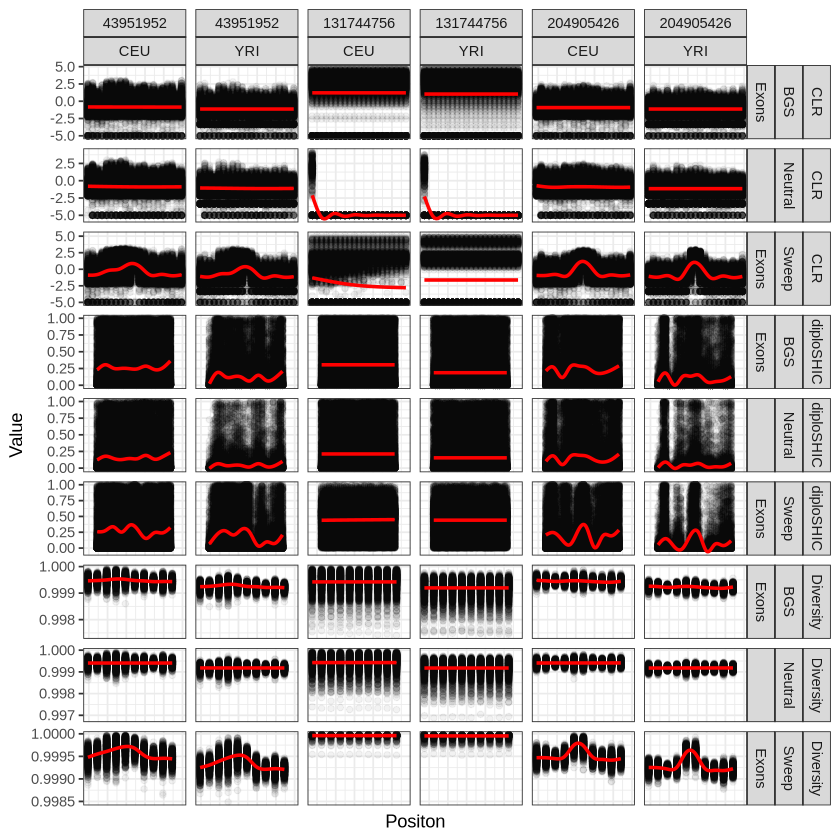

In [12]:
ggplot(df[!(df$model=="sweep" & df$annot == " ") & df$sim_left %in% sampled_locs,], aes(x=stat_left, y=ifelse(stat_name=="clr", log10(stat_val+1e-5), stat_val))) +
    geom_point(alpha=0.05)+ 
    facet_grid(stat_name+model+annot~sim_left+pop, scales="free", labeller=labeller(annot=annot_labels, stat_name=stat_labels, model=model_labels)) + 
    geom_smooth(col="red") + 
    theme_bw() + 
    labs(y="Value", x="Positon") +
    theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
ggsave(paste0("results/simulated_data/sweeps/stats_sampled_locations.pdf"), width=7.5, height=11, scale=1.5)

Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


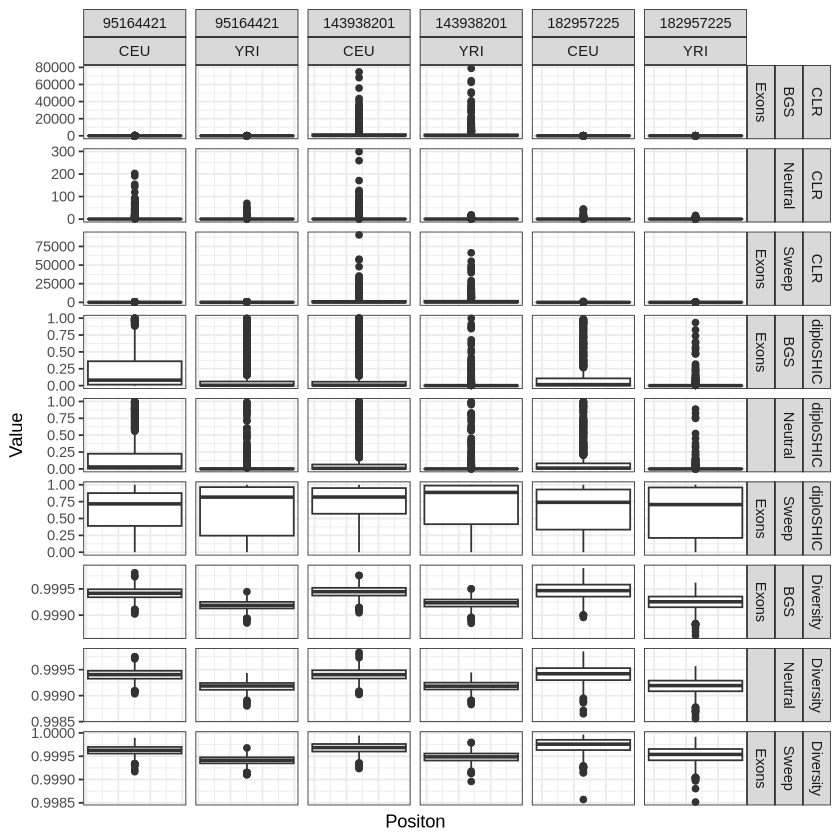

In [13]:
specific_left_locs = c(95164421, 182957225, 143938201)
dfff = df %>% filter(sw_loc > stat_left, sw_loc <= stat_right)
ggplot(dfff[!(dfff$model=="sweep" & dfff$annot == " ") & dfff$sim_left %in% specific_left_locs,], aes(x=sim_left, y=stat_val)) +
    geom_boxplot()+ 
    facet_grid(stat_name+model+annot~sim_left+pop, scales="free", labeller=labeller(annot=annot_labels, stat_name=stat_labels, model=model_labels)) + 
    geom_smooth(col="red") + 
    theme_bw() + 
    labs(y="Value", x="Positon") +
    theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
ggsave(paste0("results/simulated_data/sweeps/stats_specific_locations.pdf"), width=7.5, height=11, scale=1.5)

In [14]:
#df[!(df$model=="sweep" & df$annot == " ") & df$sim_left %in% sampled_locs[1] & df$pop=="YRI" & df$seed==1501552846 & df$stat_name=="diploshic",]

In [15]:
df %>% 
    filter(model=="sweep", 
           pop=="YRI", 
           sim_left==141499512, 
           stat_name=="clr", 
           annot==" ",
          seed==1501552846)

model demo             seed       chrom sim_left  sim_right annot dfe coeff
1  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
2  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
3  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
4  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
5  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
6  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
7  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
8  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
9  sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
10 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
11 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
12 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
13 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
14 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
15 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
16 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
17 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
18 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
19 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
20 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
21 sweep OutOfAfrica_3G09 1501552846 chr1  141499512 146499512           0.03 
   tmult pop stat_left stat_right stat_name stat_val sw_loc    cM        
1  1     YRI 141499512 141499513  clr       873.93   143999512 0.05752663
2  1     YRI 141749512 141749513  clr       873.93   143999512 0.05752663
3  1     YRI 141999512 141999513  clr       873.93   143999512 0.05752663
4  1     YRI 142249512 142249513  clr       873.93   143999512 0.05752663
5  1     YRI 142499512 142499513  clr       873.93   143999512 0.05752663
6  1     YRI 142749512 142749513  clr       873.93   143999512 0.05752663
7  1     YRI 142999512 142999513  clr       873.93   143999512 0.05752663
8  1     YRI 143249512 143249513  clr       873.93   143999512 0.05752663
9  1     YRI 143499512 143499513  clr       873.93   143999512 0.05752663
10 1     YRI 143749512 143749513  clr       873.93   143999512 0.05752663
11 1     YRI 143999512 143999512  clr       873.93   143999512 0.05752663
12 1     YRI 144249511 144249512  clr       873.93   143999512 0.05752663
13 1     YRI 144499511 144499512  clr       873.93   143999512 0.05752663
14 1     YRI 144749511 144749512  clr       873.93   143999512 0.05752663
15 1     YRI 144999511 144999512  clr       873.93   143999512 0.05752663
16 1     YRI 145249511 145249512  clr       873.93   143999512 0.05752663
17 1     YRI 145499511 145499512  clr       873.93   143999512 0.05752663
18 1     YRI 145749511 145749512  clr       873.93   143999512 0.05752663
19 1     YRI 145999511 145999512  clr       873.93   143999512 0.05752663
20 1     YRI 146249511 146249512  clr       873.93   143999512 0.05752663
21 1     YRI 146499511 146499512  clr       873.93   143999512 0.05752663
   center_cM 
1  0.01131942
2  0.01131942
3  0.01131942
4  0.01131942
5  0.01131942
6  0.01131942
7  0.01131942
8  0.01131942
9  0.01131942
10 0.01131942
11 0.01131942
12 0.01131942
13 0.01131942
14 0.01131942
15 0.01131942
16 0.01131942
17 0.01131942
18 0.01131942
19 0.01131942
20 0.01131942
21 0.01131942

In [16]:
setDT(df)
setorder(df, pop, model, demo, chrom, sim_left, annot, dfe, coeff, tmult, seed, stat_name, stat_left)


In [17]:
df_sub <- df[
  , .(
    central_max = {
      n <- .N
      if (n %% 2 == 0) {
        max(stat_val[(n / 2):(n / 2 + 1)])  # Max of two central values
      } else {
        stat_val[ceiling(n / 2)]  # Central value
      }
    }
  ),
  by = .(pop, model, demo, chrom, sim_left, sim_right, annot, dfe, coeff, tmult, seed, stat_name)
]

In [18]:
setnames(df_sub, old = "central_max", new = "stat_val")


In [19]:
df_sub %>%
    group_by(pop,model,demo,chrom,sim_left,annot,dfe,coeff,tmult, stat_name) %>%
    group_by(stat_name,pop,model,demo,chrom,annot,dfe,coeff,tmult) %>%
    summarize(mean = mean(stat_val, na.rm=TRUE))

`summarise()` has grouped output by 'stat_name', 'pop', 'model', 'demo',
'chrom', 'annot', 'dfe', 'coeff'. You can override using the `.groups`
argument.


stat_name pop model   demo             chrom annot                   
1  clr       CEU bgs     OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
2  clr       CEU neutral OutOfAfrica_3G09 chr1                          
3  clr       CEU sweep   OutOfAfrica_3G09 chr1                          
4  clr       CEU sweep   OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
5  clr       YRI bgs     OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
6  clr       YRI neutral OutOfAfrica_3G09 chr1                          
7  clr       YRI sweep   OutOfAfrica_3G09 chr1                          
8  clr       YRI sweep   OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
9  diploshic CEU bgs     OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
10 diploshic CEU neutral OutOfAfrica_3G09 chr1                          
11 diploshic CEU sweep   OutOfAfrica_3G09 chr1                          
12 diploshic CEU sweep   OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
13 diploshic YRI bgs     OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
14 diploshic YRI neutral OutOfAfrica_3G09 chr1                          
15 diploshic YRI sweep   OutOfAfrica_3G09 chr1                          
16 diploshic YRI sweep   OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
17 div       CEU bgs     OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
18 div       CEU neutral OutOfAfrica_3G09 chr1                          
19 div       CEU sweep   OutOfAfrica_3G09 chr1                          
20 div       CEU sweep   OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
21 div       YRI bgs     OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
22 div       YRI neutral OutOfAfrica_3G09 chr1                          
23 div       YRI sweep   OutOfAfrica_3G09 chr1                          
24 div       YRI sweep   OutOfAfrica_3G09 chr1  ensembl_havana_104_exons
   dfe       coeff tmult mean        
1  Gamma_K17   NA  NA    273.91916230
2              NA  NA      6.86570471
3            0.03   1    218.33721070
4  Gamma_K17 0.03   1    202.90157670
5  Gamma_K17   NA  NA    245.58831557
6              NA  NA      5.27981079
7            0.03   1    311.10728302
8  Gamma_K17 0.03   1    302.15743104
9  Gamma_K17   NA  NA      0.31796398
10             NA  NA      0.24115878
11           0.03   1      0.78823446
12 Gamma_K17 0.03   1      0.78334019
13 Gamma_K17   NA  NA      0.13292381
14             NA  NA      0.08136873
15           0.03   1      0.84107565
16 Gamma_K17 0.03   1      0.83702475
17 Gamma_K17   NA  NA      0.99950376
18             NA  NA      0.99947504
19           0.03   1      0.99975157
20 Gamma_K17 0.03   1      0.99976451
21 Gamma_K17   NA  NA      0.99927483
22             NA  NA      0.99923635
23           0.03   1      0.99957544
24 Gamma_K17 0.03   1      0.99959604

In [20]:
df_sub %>%
  group_by(pop, model, demo, chrom, sim_left, sim_right, annot, dfe, coeff, tmult, stat_name) %>%
  summarise(n=n())

`summarise()` has grouped output by 'pop', 'model', 'demo', 'chrom',
'sim_left', 'sim_right', 'annot', 'dfe', 'coeff', 'tmult'. You can override
using the `.groups` argument.


pop model demo             chrom sim_left  sim_right
1    CEU bgs   OutOfAfrica_3G09 chr1     55550   5055550 
2    CEU bgs   OutOfAfrica_3G09 chr1     55550   5055550 
3    CEU bgs   OutOfAfrica_3G09 chr1     55550   5055550 
4    CEU bgs   OutOfAfrica_3G09 chr1   2494239   7494239 
5    CEU bgs   OutOfAfrica_3G09 chr1   2494239   7494239 
6    CEU bgs   OutOfAfrica_3G09 chr1   2494239   7494239 
7    CEU bgs   OutOfAfrica_3G09 chr1   4932928   9932928 
8    CEU bgs   OutOfAfrica_3G09 chr1   4932928   9932928 
9    CEU bgs   OutOfAfrica_3G09 chr1   4932928   9932928 
10   CEU bgs   OutOfAfrica_3G09 chr1   7371617  12371617 
11   CEU bgs   OutOfAfrica_3G09 chr1   7371617  12371617 
12   CEU bgs   OutOfAfrica_3G09 chr1   7371617  12371617 
13   CEU bgs   OutOfAfrica_3G09 chr1   9810306  14810306 
14   CEU bgs   OutOfAfrica_3G09 chr1   9810306  14810306 
15   CEU bgs   OutOfAfrica_3G09 chr1   9810306  14810306 
16   CEU bgs   OutOfAfrica_3G09 chr1  12248995  17248995 
17   CEU bgs   OutOfAfrica_3G09 chr1  12248995  17248995 
18   CEU bgs   OutOfAfrica_3G09 chr1  12248995  17248995 
19   CEU bgs   OutOfAfrica_3G09 chr1  14687684  19687684 
20   CEU bgs   OutOfAfrica_3G09 chr1  14687684  19687684 
21   CEU bgs   OutOfAfrica_3G09 chr1  14687684  19687684 
22   CEU bgs   OutOfAfrica_3G09 chr1  17126373  22126373 
23   CEU bgs   OutOfAfrica_3G09 chr1  17126373  22126373 
24   CEU bgs   OutOfAfrica_3G09 chr1  17126373  22126373 
25   CEU bgs   OutOfAfrica_3G09 chr1  19565062  24565062 
26   CEU bgs   OutOfAfrica_3G09 chr1  19565062  24565062 
27   CEU bgs   OutOfAfrica_3G09 chr1  19565062  24565062 
28   CEU bgs   OutOfAfrica_3G09 chr1  22003751  27003751 
29   CEU bgs   OutOfAfrica_3G09 chr1  22003751  27003751 
30   CEU bgs   OutOfAfrica_3G09 chr1  22003751  27003751 
⋮    ⋮   ⋮     ⋮                ⋮     ⋮         ⋮        
2371 YRI sweep OutOfAfrica_3G09 chr1  231731005 236731005
2372 YRI sweep OutOfAfrica_3G09 chr1  231731005 236731005
2373 YRI sweep OutOfAfrica_3G09 chr1  231731005 236731005
2374 YRI sweep OutOfAfrica_3G09 chr1  231731005 236731005
2375 YRI sweep OutOfAfrica_3G09 chr1  231731005 236731005
2376 YRI sweep OutOfAfrica_3G09 chr1  231731005 236731005
2377 YRI sweep OutOfAfrica_3G09 chr1  234169694 239169694
2378 YRI sweep OutOfAfrica_3G09 chr1  234169694 239169694
2379 YRI sweep OutOfAfrica_3G09 chr1  234169694 239169694
2380 YRI sweep OutOfAfrica_3G09 chr1  234169694 239169694
2381 YRI sweep OutOfAfrica_3G09 chr1  234169694 239169694
2382 YRI sweep OutOfAfrica_3G09 chr1  234169694 239169694
2383 YRI sweep OutOfAfrica_3G09 chr1  236608383 241608383
2384 YRI sweep OutOfAfrica_3G09 chr1  236608383 241608383
2385 YRI sweep OutOfAfrica_3G09 chr1  236608383 241608383
2386 YRI sweep OutOfAfrica_3G09 chr1  236608383 241608383
2387 YRI sweep OutOfAfrica_3G09 chr1  236608383 241608383
2388 YRI sweep OutOfAfrica_3G09 chr1  236608383 241608383
2389 YRI sweep OutOfAfrica_3G09 chr1  239047072 244047072
2390 YRI sweep OutOfAfrica_3G09 chr1  239047072 244047072
2391 YRI sweep OutOfAfrica_3G09 chr1  239047072 244047072
2392 YRI sweep OutOfAfrica_3G09 chr1  239047072 244047072
2393 YRI sweep OutOfAfrica_3G09 chr1  239047072 244047072
2394 YRI sweep OutOfAfrica_3G09 chr1  239047072 244047072
2395 YRI sweep OutOfAfrica_3G09 chr1  241485761 246485761
2396 YRI sweep OutOfAfrica_3G09 chr1  241485761 246485761
2397 YRI sweep OutOfAfrica_3G09 chr1  241485761 246485761
2398 YRI sweep OutOfAfrica_3G09 chr1  241485761 246485761
2399 YRI sweep OutOfAfrica_3G09 chr1  241485761 246485761
2400 YRI sweep OutOfAfrica_3G09 chr1  241485761 246485761
     annot                    dfe       coeff tmult stat_name n   
1    ensembl_havana_104_exons Gamma_K17 NA    NA    clr       1000
2    ensembl_havana_104_exons Gamma_K17 NA    NA    diploshic 1000
3    ensembl_havana_104_exons Gamma_K17 NA    NA    div       1000
4    ensembl_havana_104_exons Gamma_K17 NA    NA    clr       1000
5    ensembl_havana_104_exons Gamma_K17 NA    NA    diploshic 1000
6    en

In [21]:
set.seed(123)  # Set seed for reproducibility

# Create training and test sets
df_sub <- df_sub %>%
  group_by(pop, model, demo, chrom, sim_left, sim_right, annot, dfe, coeff, tmult, stat_name) %>%
  mutate(row_id = row_number()) %>%
  mutate(set = if_else(row_id %in% sample(row_id, size = 800), "train", "test")) %>%
  ungroup() %>%
  select(-row_id)

In [22]:
df_sub[df_sub$model=="sweep",]$set = "test" # all sweep sims are test

In [23]:
unique(df_sub$model)

[1] "bgs"     "neutral" "sweep"

In [24]:
summary(df_sub$sim_right-df_sub$sim_left)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5e+06   5e+06   5e+06   5e+06   5e+06   5e+06 

In [25]:
df_sub = left_join(df_sub, rec_map)
df_sub$rec_rate = df_sub$cM/5e6
df_sub$center_rec_rate = df_sub$center_cM/1e6

Joining with `by = join_by(chrom, sim_left, sim_right)`


In [26]:
df_sub$plot_val <- ifelse(df_sub$stat_name == "div", 
                         1 - df_sub$stat_val,
                         ifelse(df_sub$stat_name == "clr",
                                log10(df_sub$stat_val+1e-7),
                                df_sub$stat_val))

In [27]:
#sweeps_df = df_sub[df_sub$model=="sweep",]
#neutral_df = df_sub[df_sub$model=="neutral",]
#bgs_df = df_sub[df_sub$model=="bgs",]

In [28]:
stat_labels_mod = c("clr"="logCLR", "diploshic"="diploSHIC","div"="Diversity")

Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x


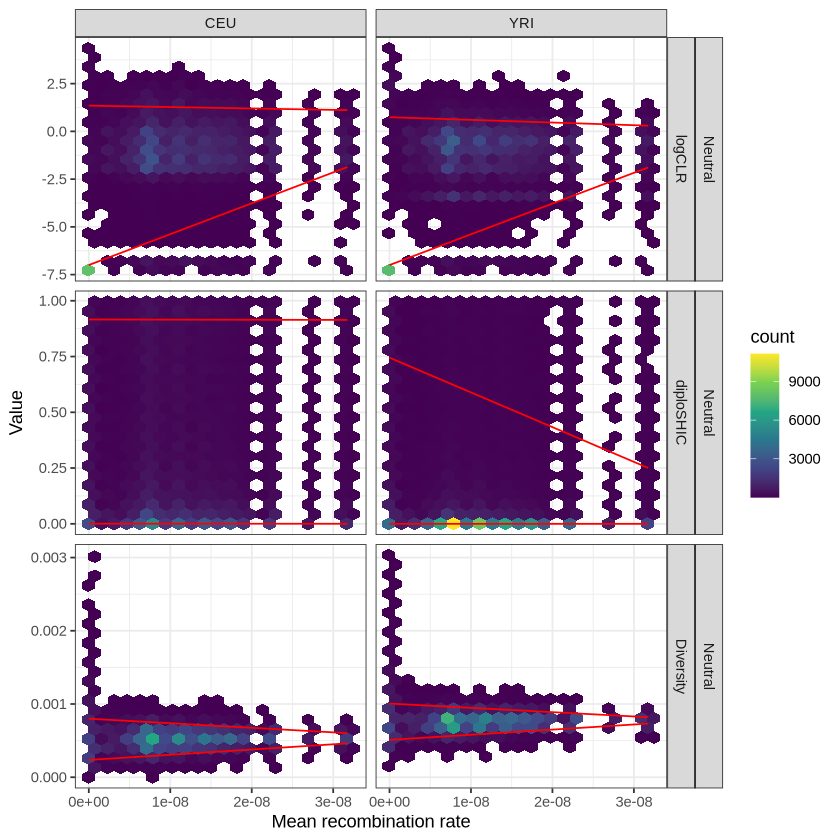

In [29]:
ggplot(df_sub[df_sub$model=="neutral",], aes(x = center_rec_rate, y = plot_val)) +
    geom_hex(bins=20)+
    facet_grid(model+stat_name~pop, scale="free", labeller=labeller(stat_name=stat_labels_mod, model=model_labels)) +
    stat_quantile(quantiles = c(0.05, 0.95), colour="red") +
    theme_bw() +
    labs(x="Mean recombination rate", y="Value") +
    scale_fill_viridis_c()
ggsave(paste0("results/simulated_data/sweeps/neutral_relationship_stat-vals_cM.pdf"), width=9.5, height=9.5, scale=1.)

Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x
Smoothing formula not specified. Using: y ~ x


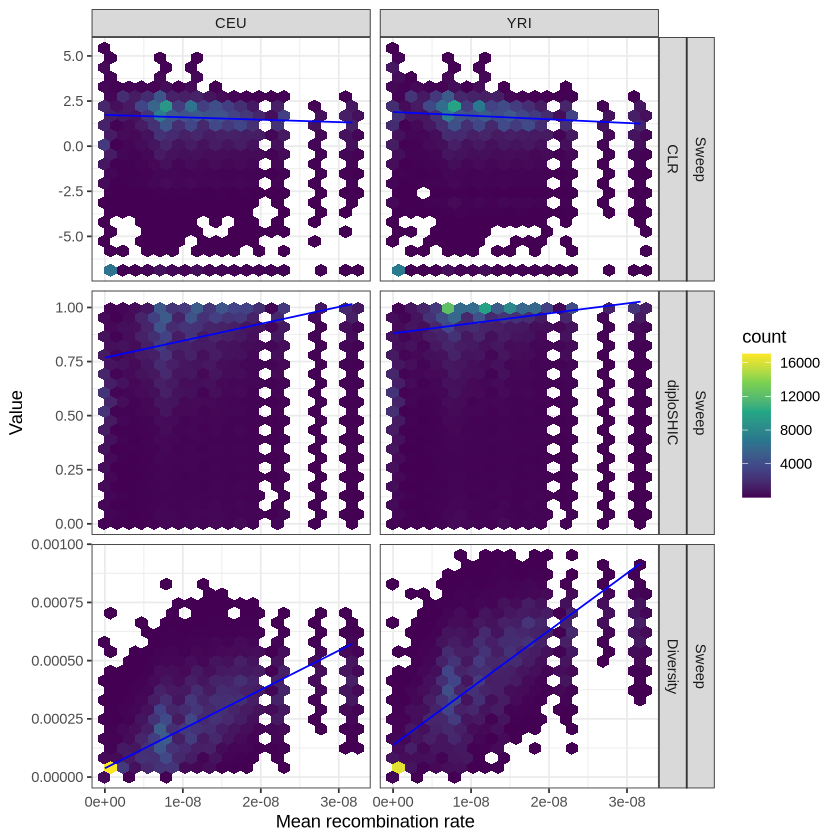

In [30]:
ggplot(df_sub[df_sub$model=="sweep",], aes(x = center_rec_rate, y = plot_val)) +
    geom_hex(bins=20)+
    facet_grid(model+stat_name~pop, scale="free", labeller=labeller(stat_name=stat_labels, model=model_labels)) +
    stat_quantile(quantiles = c(0.5), colour="blue") +
    theme_bw() +
    labs(x="Mean recombination rate", y="Value") +
    scale_fill_viridis_c()
ggsave(paste0("results/simulated_data/sweeps/sweep_relationship_stat-vals_cM.pdf"), width=9.5, height=9.5, scale=1.)

In [31]:
summary(df_sub$center_cM)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.006945 0.010576 0.011196 0.015253 0.031744 

In [32]:
global_neut_q5s = df_sub[df_sub$model == "neutral" & df_sub$center_cM > 0.001 & df_sub$set=="train",] %>% group_by(pop, stat_name) %>% summarize(neut_thresh = as.vector(quantile(stat_val, c(0.95), na.rm=T)))
global_bgs_q5s = df_sub[df_sub$model == "bgs" & df_sub$center_cM > 0.001 & df_sub$set=="train",] %>% group_by(pop, stat_name) %>% summarize(bgs_thresh = as.vector(quantile(stat_val, c(0.95), na.rm=T)))
#global_neut_q5s[global_neut_q5s$stat_name=="diploshic",]$neut_thresh = 0.5
#global_bgs_q5s[global_neut_q5s$stat_name=="diploshic",]$bgs_thresh = 0.5
df_sub = left_join(df_sub, global_neut_q5s)
df_sub = left_join(df_sub, global_bgs_q5s)
global_neut_q5s
global_bgs_q5s

`summarise()` has grouped output by 'pop'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'pop'. You can override using the `.groups`
argument.
Joining with `by = join_by(pop, stat_name)`
Joining with `by = join_by(pop, stat_name)`


pop stat_name neut_thresh
1 CEU clr       20.2482500 
2 CEU diploshic  0.9162800 
3 CEU div        0.9996689 
4 YRI clr        3.3788750 
5 YRI diploshic  0.4978080 
6 YRI div        0.9993917

pop stat_name bgs_thresh
1 CEU clr       29.8303000
2 CEU diploshic  0.9506510
3 CEU div        0.9997060
4 YRI clr        5.1264400
5 YRI diploshic  0.7616215
6 YRI div        0.9994516

In [33]:
compute_rates = function(df, neut, bgs, agg=FALSE) {
    print("gothere")
    df = df[df$center_cM >= 0.001,]
    df$neut_thresh = NULL
    df$bgs_thresh = NULL
    print(neut)
    print(bgs)
    df = left_join(df, neut, by=c("stat_name","pop"))
    df = left_join(df, bgs, by=c("stat_name","pop"))
    print(summary(df$neut_thresh))
    print(summary(df$bgs_thresh))
    df$neut_is_neg = df$stat_val < df$neut_thresh
    df$bgs_is_neg = df$stat_val < df$bgs_thresh
    print(sum(df$neut_is_neg))
    print(sum(df$bgs_is_neg))
    col_names = c("stat_name","sim_left", "model", "annot", "pop", "coeff", "center_cM", "cM", "rec_rate", "center_rec_rate", "chrom")
    if(agg) {
        col_names = c("stat_name", "model", "annot", "pop", "coeff")
    }
    
    print("gothere2")
    sub_summary = df %>% filter(set=="test") %>% group_by(!!!syms(col_names)) %>% summarise(neut_num_neg = sum(neut_is_neg),bgs_num_neg = sum(bgs_is_neg), total=n())
    print("gothere3")
    if(!agg){
        sub_summary = left_join(sub_summary, annot_map)
        sub_summary = left_join(sub_summary, rec_map)
        sub_summary$rec_rate = sub_summary$cM/5e6
        sub_summary$center_rec_rate = sub_summary$center_cM/1e6
    }
    sweeps_summary = sub_summary[sub_summary$model=="sweep",]
    neutral_summary = sub_summary[sub_summary$model=="neutral",]
    bgs_summary = sub_summary[sub_summary$model=="bgs",]
    sweeps_summary$neut_fnr = sweeps_summary$neut_num_neg / sweeps_summary$total
    sweeps_summary$neut_tpr = 1 - sweeps_summary$neut_fnr
    sweeps_summary$bgs_fnr = sweeps_summary$bgs_num_neg / sweeps_summary$total
    sweeps_summary$bgs_tpr = 1 - sweeps_summary$bgs_fnr
    
    neutral_summary$tnr = neutral_summary$neut_num_neg / neutral_summary$total
    neutral_summary$fpr = 1 - neutral_summary$tnr
    
    bgs_summary$tnr = bgs_summary$bgs_num_neg / bgs_summary$total
    bgs_summary$fpr = 1 - bgs_summary$tnr
    bgs_summary$neut_tnr = bgs_summary$neut_num_neg / bgs_summary$total
    bgs_summary$neut_fpr = 1 - bgs_summary$neut_tnr
    print("gotherelast")
    return(list(`sweeps`=sweeps_summary, `neutral`=neutral_summary,`bgs`=bgs_summary))
}

In [34]:
split_list = compute_rates(df_sub, global_neut_q5s, global_bgs_q5s)

[1] "gothere"
# A tibble: 6 × 3
# Groups:   pop [2]
  pop   stat_name neut_thresh
  <chr> <chr>           <dbl>
1 CEU   clr            20.2  
2 CEU   diploshic       0.916
3 CEU   div             1.00 
4 YRI   clr             3.38 
5 YRI   diploshic       0.498
6 YRI   div             0.999
# A tibble: 6 × 3
# Groups:   pop [2]
  pop   stat_name bgs_thresh
  <chr> <chr>          <dbl>
1 CEU   clr           29.8  
2 CEU   diploshic      0.951
3 CEU   div            1.00 
4 YRI   clr            5.13 
5 YRI   diploshic      0.762
6 YRI   div            0.999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4978  0.9163  0.9995  4.5067  3.3789 20.2482 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7616  0.9507  0.9996  6.4447  5.1264 29.8303 
[1] 1324429
[1] 1450049
[1] "gothere2"


`summarise()` has grouped output by 'stat_name', 'sim_left', 'model', 'annot',
'pop', 'coeff', 'center_cM', 'cM', 'rec_rate', 'center_rec_rate'. You can
override using the `.groups` argument.


[1] "gothere3"


Joining with `by = join_by(sim_left, annot)`
Joining with `by = join_by(sim_left, center_cM, cM, chrom, sim_right)`


[1] "gotherelast"


In [35]:
df = df_sub
neut=global_neut_q5s
bgs=global_bgs_q5s
df = df[df$center_cM >= 0.001,]
df$neut_thresh = NULL
df$bgs_thresh = NULL
print(neut)
print(bgs)
df = left_join(df, neut, by=c("stat_name","pop"))
df = left_join(df, bgs, by=c("stat_name","pop"))
print(summary(df$neut_thresh))
print(summary(df$bgs_thresh))
df$neut_is_neg = df$stat_val < df$neut_thresh
df$bgs_is_neg = df$stat_val < df$bgs_thresh

# A tibble: 6 × 3
# Groups:   pop [2]
  pop   stat_name neut_thresh
  <chr> <chr>           <dbl>
1 CEU   clr            20.2  
2 CEU   diploshic       0.916
3 CEU   div             1.00 
4 YRI   clr             3.38 
5 YRI   diploshic       0.498
6 YRI   div             0.999
# A tibble: 6 × 3
# Groups:   pop [2]
  pop   stat_name bgs_thresh
  <chr> <chr>          <dbl>
1 CEU   clr           29.8  
2 CEU   diploshic      0.951
3 CEU   div            1.00 
4 YRI   clr            5.13 
5 YRI   diploshic      0.762
6 YRI   div            0.999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4978  0.9163  0.9995  4.5067  3.3789 20.2482 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7616  0.9507  0.9996  6.4447  5.1264 29.8303 


In [36]:
diplo_sweeps_df = df[df$model=="sweep" & df$stat_name=="diploshic" & df$annot==" " & df$pop=="YRI",]
diplo_sweeps_df$fvec_path = paste0("/home/murillor/projects/analysis2/results/simulated_data/sweeps/sweep/OutOfAfrica_3G09/YRI/NA/NA/0.03/1/",diplo_sweeps_df$seed,"/sim_chr1_",diplo_sweeps_df$sim_left,"_",diplo_sweeps_df$sim_right,"_YRI.diploshic.fv")


In [37]:
write_tsv(diplo_sweeps_df[!diplo_sweeps_df$neut_is_neg,c("fvec_path")], "diploshic_TP_fv_paths.tsv", col_names = FALSE)

In [38]:
write_tsv(diplo_sweeps_df[diplo_sweeps_df$neut_is_neg,c("fvec_path")], "diploshic_FN_fv_paths.tsv", col_names = FALSE)

In [39]:
df_sub$neut_thresh=NULL
df_sub$bgs_thresh=NULL

In [40]:
p1_df = split_list$sweeps[split_list$sweeps$annot!=" ",] # just looking at the sims with sweeps and BGS
p1_df =  p1_df %>%
    select(stat_name:coeff, neut_tpr, bgs_tpr, sim_right, cM, center_cM, center_rec_rate, rec_rate, chrom, overlap) %>%
    pivot_longer(neut_tpr:bgs_tpr, names_pattern="(.*)_tpr")
p1_df$name[p1_df$name=="neut"] = "Neutral"
p1_df$name[p1_df$name=="bgs"] = "BGS"

In [41]:
colpal = c('#D41159','#1A85FF')

In [42]:
p1_df[p1_df$sim_left==82970976,]

stat_name sim_left model annot                    pop coeff sim_right
1  clr       82970976 sweep ensembl_havana_104_exons CEU 0.03  87970976 
2  clr       82970976 sweep ensembl_havana_104_exons CEU 0.03  87970976 
3  clr       82970976 sweep ensembl_havana_104_exons YRI 0.03  87970976 
4  clr       82970976 sweep ensembl_havana_104_exons YRI 0.03  87970976 
5  diploshic 82970976 sweep ensembl_havana_104_exons CEU 0.03  87970976 
6  diploshic 82970976 sweep ensembl_havana_104_exons CEU 0.03  87970976 
7  diploshic 82970976 sweep ensembl_havana_104_exons YRI 0.03  87970976 
8  diploshic 82970976 sweep ensembl_havana_104_exons YRI 0.03  87970976 
9  div       82970976 sweep ensembl_havana_104_exons CEU 0.03  87970976 
10 div       82970976 sweep ensembl_havana_104_exons CEU 0.03  87970976 
11 div       82970976 sweep ensembl_havana_104_exons YRI 0.03  87970976 
12 div       82970976 sweep ensembl_havana_104_exons YRI 0.03  87970976 
   cM         center_cM   center_rec_rate rec_rate     chrom overlap   name   
1  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 Neutral
2  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 BGS    
3  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 Neutral
4  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 BGS    
5  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 Neutral
6  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 BGS    
7  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 Neutral
8  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 BGS    
9  0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 Neutral
10 0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 BGS    
11 0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 Neutral
12 0.05802256 0.007742401 7.742401e-09    1.160451e-08 chr1  0.0231194 BGS    
   value
1  0.495
2  0.436
3  0.669
4  0.627
5  0.315
6  0.229
7  0.845
8  0.767
9  0.830
10 0.735
11 0.945
12 0.874

In [43]:
library(ggplot2)
library(plotly)

# Create the ggplot
p <- p1_df %>% ggplot(aes(y = value, x = center_cM, col = name, text = paste("sim_left: ", sim_left, "<br>sim_right: ", sim_right))) +
  geom_point() +
  facet_grid(stat_name ~ pop, labeller = labeller(stat_name = stat_labels)) +
  geom_smooth() +
  ylim(0, 1) +
  scale_colour_manual(values = colpal) +
  labs(x = "cM", y = "Power (TPR)", col = "Null model") +
  theme_bw()

# Convert to plotly for interactivity
p_interactive <- ggplotly(p, tooltip = "text")

# Save the static ggplot as a PDF
ggsave(paste0("results/simulated_data/sweeps/relationship_power_cM.pdf"), plot = p, width = 9.5, height = 9.5, scale = 1.)

# Display the interactive plot
p_interactive


Warning message:
“package ‘plotly’ was built under R version 4.3.2”

Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


HTML widgets cannot be represented in plain text (need html)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_smooth()`).”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_smooth()`).”


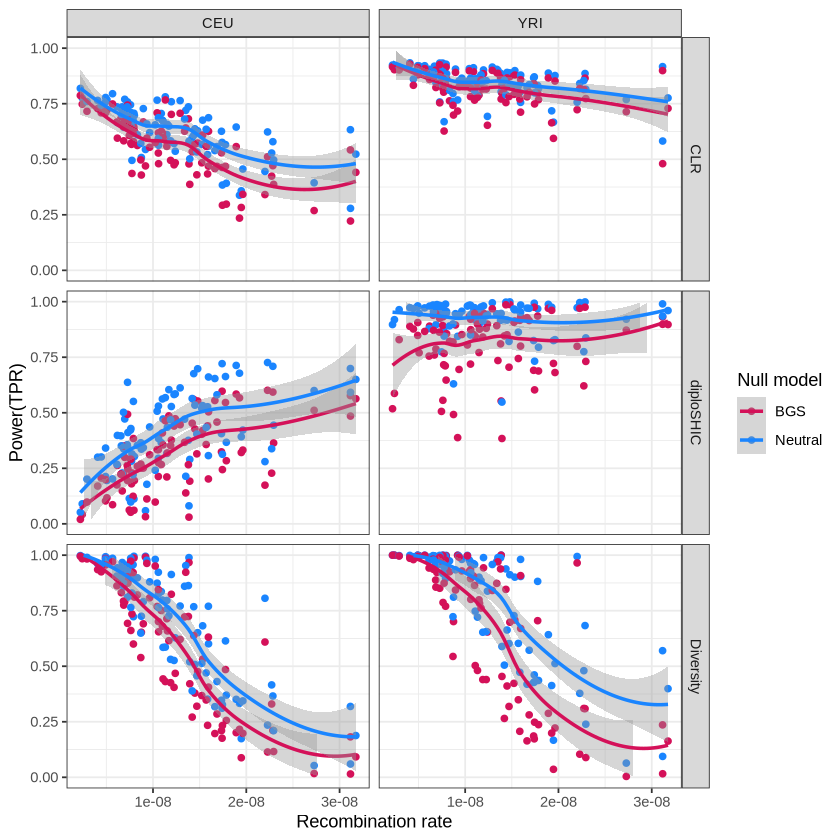

In [44]:
p1_df %>% ggplot(aes(y=value,x=center_rec_rate, col=name)) +
    geom_point() +
    facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_smooth() + 
    ylim(0,1) + 
    scale_colour_manual(values =colpal)+
    labs(x="Recombination rate",y="Power(TPR)", col="Null model")+
    theme_bw()
ggsave(paste0("results/simulated_data/sweeps/relationship_power_cM.pdf"), width=9.5, height=9.5, scale=1.)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


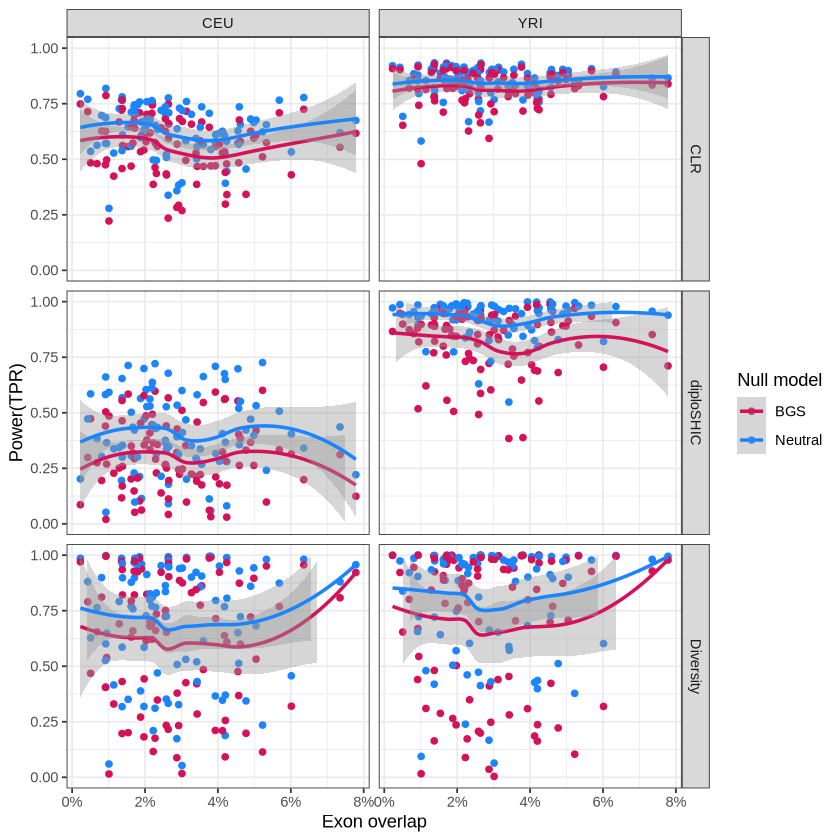

In [45]:
p1_df %>% ggplot(aes(y=value,x=overlap, col=name)) +
    geom_point() +
    facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_smooth() + 
    ylim(0,1) + 
    scale_colour_manual(values =colpal)+
    scale_x_continuous(labels = scales::percent) +
    labs(x="Exon overlap",y="Power(TPR)", col="Null model")+
    theme_bw()

In [46]:
ggsave(paste0("results/simulated_data/sweeps/relationship_power_exon.pdf"), width=9.5, height=9.5, scale=1.)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


In [47]:
p1 = ggplot(p1_df, aes(y=value, x=sim_left)) + 
    geom_line(aes(col=name)) + facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.05, ymax=0.00, fill=center_rec_rate))+ labs(fill="Recombination rate")+
    scale_fill_viridis_c(option="D") +
    new_scale_fill() +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.1, ymax=-.05, fill=overlap))+
    scale_fill_viridis_c(option="B", labels=label_percent()) +
    labs(x="Position", y="Power (TPR)", col="Null model", fill="Exon overlap") +
    theme_bw() + ylim(-0.1,1) + scale_colour_manual(values =colpal)

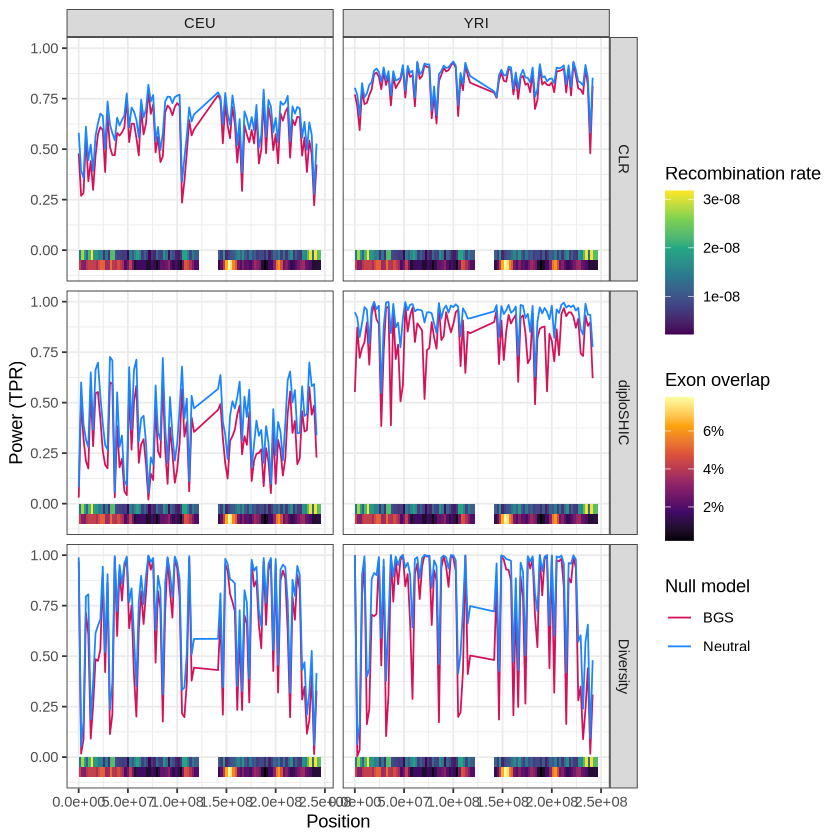

In [48]:
p1
ggsave(paste0("results/simulated_data/sweeps/chr1_power.pdf"), width=8.5, height=11)

In [49]:
p2_df = split_list$bgs[split_list$bgs$annot!=" ",] # just looking at the sims with sweeps and BGS
p2_df =  p2_df %>%
    select(stat_name:coeff, tnr, fpr, sim_right, cM, center_cM, rec_rate, center_rec_rate, chrom, overlap) %>%
    pivot_longer(tnr:fpr)
#p2_df$name[p2_df$name=="neut"] = "Neutral"
#p2_df$name[p2_df$name=="bgs"] = "BGS"

In [50]:
p2_df[p2_df$name=="fpr",][p2_df[p2_df$name=="fpr",]$value>0.65,]

stat_name sim_left  model annot                    pop coeff sim_right
1 clr       141499512 bgs   ensembl_havana_104_exons CEU NA    146499512
2 clr       141499512 bgs   ensembl_havana_104_exons YRI NA    146499512
3 clr       143938201 bgs   ensembl_havana_104_exons CEU NA    148938201
4 clr       143938201 bgs   ensembl_havana_104_exons YRI NA    148938201
  cM         center_cM   rec_rate     center_rec_rate chrom overlap   name
1 0.05752663 0.011319418 1.150533e-08 1.131942e-08    chr1  0.0137244 fpr 
2 0.05752663 0.011319418 1.150533e-08 1.131942e-08    chr1  0.0137244 fpr 
3 0.07350456 0.007272879 1.470091e-08 7.272879e-09    chr1  0.0220176 fpr 
4 0.07350456 0.007272879 1.470091e-08 7.272879e-09    chr1  0.0220176 fpr 
  value
1 0.725
2 0.715
3 0.735
4 0.685

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


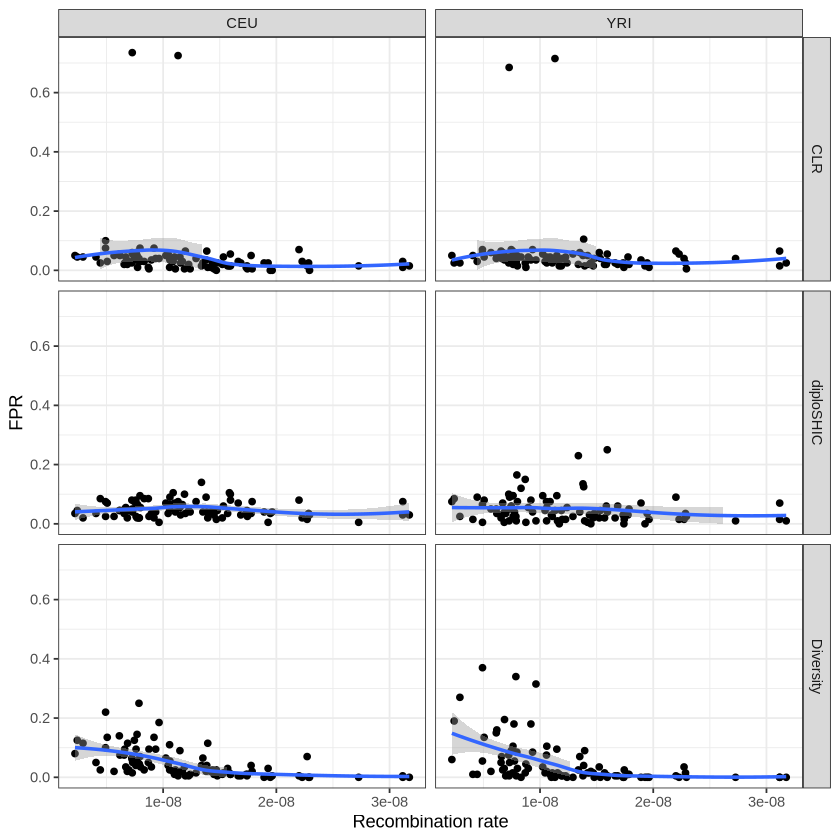

In [51]:
p2_df[p2_df$name=="fpr",] %>% ggplot(aes(y=value,x=center_rec_rate)) +
    geom_point() +
    facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_smooth() + 
    ylim(0,0.75) + 
    labs(x="Recombination rate",y="FPR")+
    theme_bw()
ggsave(paste0("results/simulated_data/sweeps/relationship_fpr_cM.pdf"), width=9.5, height=9.5, scale=1.)

In [52]:
p2 = ggplot(p2_df[p2_df$name=="fpr",], aes(y=value, x=sim_left)) + 
    geom_point(aes(alpha=0.5, shape=".")) +
    geom_line() + facet_grid(stat_name~pop, labeller=labeller(stat_name=stat_labels)) +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.05, ymax=0.00, fill=center_rec_rate))+ labs(fill="Recombination rate")+
    scale_fill_viridis_c(option="D") +
    new_scale_fill() +
    geom_rect(aes(xmin=sim_left, xmax=sim_right, ymin=-.1, ymax=-.05, fill=overlap))+
    scale_fill_viridis_c(option="B", labels=label_percent()) +
    labs(x="Position", y="FPR", col="Null model", fill="Exon overlap") +
    theme_bw() + ylim(-0.1,1) + scale_colour_manual(values =colpal)

In [53]:
p2_df[p2_df$stat_name=="clr" & p2_df$name=="fpr" & p2_df$pop=="YRI",]

stat_name sim_left  model annot                    pop coeff sim_right
1  clr          55550  bgs   ensembl_havana_104_exons YRI NA     5055550 
2  clr        2494239  bgs   ensembl_havana_104_exons YRI NA     7494239 
3  clr        4932928  bgs   ensembl_havana_104_exons YRI NA     9932928 
4  clr        7371617  bgs   ensembl_havana_104_exons YRI NA    12371617 
5  clr        9810306  bgs   ensembl_havana_104_exons YRI NA    14810306 
6  clr       12248995  bgs   ensembl_havana_104_exons YRI NA    17248995 
7  clr       14687684  bgs   ensembl_havana_104_exons YRI NA    19687684 
8  clr       17126373  bgs   ensembl_havana_104_exons YRI NA    22126373 
9  clr       19565062  bgs   ensembl_havana_104_exons YRI NA    24565062 
10 clr       22003751  bgs   ensembl_havana_104_exons YRI NA    27003751 
11 clr       24442440  bgs   ensembl_havana_104_exons YRI NA    29442440 
12 clr       26881129  bgs   ensembl_havana_104_exons YRI NA    31881129 
13 clr       29319818  bgs   ensembl_havana_104_exons YRI NA    34319818 
14 clr       31758507  bgs   ensembl_havana_104_exons YRI NA    36758507 
15 clr       34197196  bgs   ensembl_havana_104_exons YRI NA    39197196 
16 clr       36635885  bgs   ensembl_havana_104_exons YRI NA    41635885 
17 clr       39074574  bgs   ensembl_havana_104_exons YRI NA    44074574 
18 clr       41513263  bgs   ensembl_havana_104_exons YRI NA    46513263 
19 clr       43951952  bgs   ensembl_havana_104_exons YRI NA    48951952 
20 clr       46390641  bgs   ensembl_havana_104_exons YRI NA    51390641 
21 clr       48829330  bgs   ensembl_havana_104_exons YRI NA    53829330 
22 clr       51268019  bgs   ensembl_havana_104_exons YRI NA    56268019 
23 clr       53706708  bgs   ensembl_havana_104_exons YRI NA    58706708 
24 clr       56145397  bgs   ensembl_havana_104_exons YRI NA    61145397 
25 clr       58584086  bgs   ensembl_havana_104_exons YRI NA    63584086 
26 clr       61022775  bgs   ensembl_havana_104_exons YRI NA    66022775 
27 clr       63461464  bgs   ensembl_havana_104_exons YRI NA    68461464 
28 clr       65900153  bgs   ensembl_havana_104_exons YRI NA    70900153 
29 clr       68338842  bgs   ensembl_havana_104_exons YRI NA    73338842 
30 clr       70777531  bgs   ensembl_havana_104_exons YRI NA    75777531 
⋮  ⋮         ⋮         ⋮     ⋮                        ⋮   ⋮     ⋮        
62 clr       170763780 bgs   ensembl_havana_104_exons YRI NA    175763780
63 clr       173202469 bgs   ensembl_havana_104_exons YRI NA    178202469
64 clr       175641158 bgs   ensembl_havana_104_exons YRI NA    180641158
65 clr       178079847 bgs   ensembl_havana_104_exons YRI NA    183079847
66 clr       180518536 bgs   ensembl_havana_104_exons YRI NA    185518536
67 clr       182957225 bgs   ensembl_havana_104_exons YRI NA    187957225
68 clr       185395914 bgs   ensembl_havana_104_exons YRI NA    190395914
69 clr       187834603 bgs   ensembl_havana_104_exons YRI NA    192834603
70 clr       190273292 bgs   ensembl_havana_104_exons YRI NA    195273292
71 clr       192711981 bgs   ensembl_havana_104_exons YRI NA    197711981
72 clr       195150670 bgs   ensembl_havana_104_exons YRI NA    200150670
73 clr       197589359 bgs   ensembl_havana_104_exons YRI NA    202589359
74 clr       200028048 bgs   ensembl_havana_104_exons YRI NA    205028048
75 clr       202466737 bgs   ensembl_havana_104_exons YRI NA    207466737
76 clr       204905426 bgs   ensembl_havana_104_exons YRI NA    209905426
77 clr       207344115 bgs   ensembl_havana_104_exons YRI NA    212344115
78 clr       209782804 bgs   ensembl_havana_104_exons YRI NA    214782804
79 clr       212221493 bgs   ensembl_havana_104_exons YRI NA    217221493
80 clr       214660182 bgs   ensembl_havana_104_exons YRI NA    219660182
81 clr       217098871 bgs   ensembl_havana_104_exons YRI NA    222098871
82 clr       219537560 bgs   ensembl_havana_104_exons YRI NA    224537560
83 clr       221976249 bgs   ensembl_havana_104_exons YRI NA    226976249
84 clr 

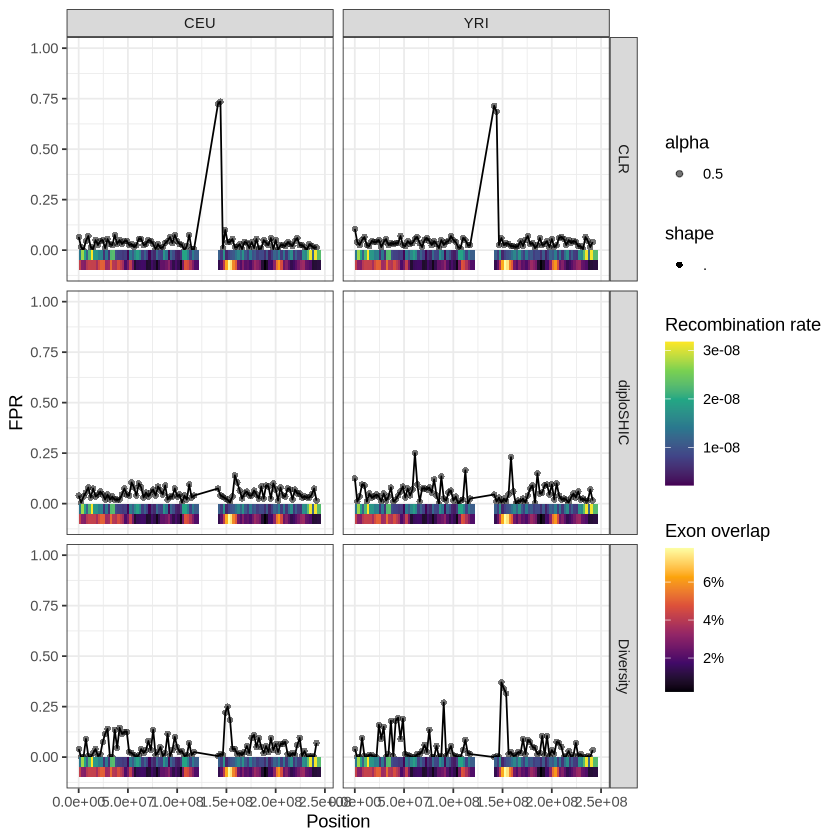

In [54]:
p2

In [55]:
agg_split_list = compute_rates(df_sub[df_sub$set=="test",], global_neut_q5s, global_bgs_q5s, agg=TRUE)
agg_split_list

[1] "gothere"
# A tibble: 6 × 3
# Groups:   pop [2]
  pop   stat_name neut_thresh
  <chr> <chr>           <dbl>
1 CEU   clr            20.2  
2 CEU   diploshic       0.916
3 CEU   div             1.00 
4 YRI   clr             3.38 
5 YRI   diploshic       0.498
6 YRI   div             0.999
# A tibble: 6 × 3
# Groups:   pop [2]
  pop   stat_name bgs_thresh
  <chr> <chr>          <dbl>
1 CEU   clr           29.8  
2 CEU   diploshic      0.951
3 CEU   div            1.00 
4 YRI   clr            5.13 
5 YRI   diploshic      0.762
6 YRI   div            0.999
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4978  0.9163  0.9995  4.5067  3.3789 20.2482 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7616  0.9507  0.9996  6.4447  5.1264 29.8303 
[1] 510064
[1] 610796
[1] "gothere2"


`summarise()` has grouped output by 'stat_name', 'model', 'annot', 'pop'. You
can override using the `.groups` argument.


[1] "gothere3"
[1] "gotherelast"


$sweeps
# A tibble: 12 × 12
# Groups:   stat_name, model, annot, pop [12]
   stat_name model annot     pop   coeff neut_num_neg bgs_num_neg total neut_fnr
   <chr>     <chr> <chr>     <chr> <dbl>        <int>       <int> <int>    <dbl>
 1 clr       sweep " "       CEU    0.03        32592       38724 91000   0.358 
 2 clr       sweep " "       YRI    0.03        13169       15665 91000   0.145 
 3 clr       sweep "ensembl… CEU    0.03        33519       39940 91000   0.368 
 4 clr       sweep "ensembl… YRI    0.03        13542       16117 91000   0.149 
 5 diploshic sweep " "       CEU    0.03        52037       61977 91000   0.572 
 6 diploshic sweep " "       YRI    0.03         6208       15623 91000   0.0682
 7 diploshic sweep "ensembl… CEU    0.03        53191       63111 91000   0.585 
 8 diploshic sweep "ensembl… YRI    0.03         6532       16185 91000   0.0718
 9 div       sweep " "       CEU    0.03        30391       38707 91000   0.334 
10 div       sweep " "       YRI    0.03        21417       32411 91000   0.235 
11 div       sweep "ensembl… CEU    0.03        26631       34803 91000   0.293 
12 div       sweep "ensembl… YRI    0.03        17115       27615 91000   0.188 
# ℹ 3 more variables: neut_tpr <dbl>, bgs_fnr <dbl>, bgs_tpr <dbl>

$neutral
# A tibble: 6 × 10
# Groups:   stat_name, model, annot, pop [6]
  stat_name model  annot pop   coeff neut_num_neg bgs_num_neg total   tnr    fpr
  <chr>     <chr>  <chr> <chr> <dbl>        <int>       <int> <int> <dbl>  <dbl>
1 clr       neutr… " "   CEU      NA        17298       17536 18200 0.950 0.0496
2 clr       neutr… " "   YRI      NA        17289       17578 18200 0.950 0.0501
3 diploshic neutr… " "   CEU      NA        17318       17627 18200 0.952 0.0485
4 diploshic neutr… " "   YRI      NA        17251       17702 18200 0.948 0.0521
5 div       neutr… " "   CEU      NA        17276       17690 18200 0.949 0.0508
6 div       neutr… " "   YRI      NA        17276       17957 18200 0.949 0.0508

$bgs
# A tibble: 6 × 12
# Groups:   stat_name, model, annot, pop [6]
  stat_name model annot  pop   coeff neut_num_neg bgs_num_neg total   tnr    fpr
  <chr>     <chr> <chr>  <chr> <dbl>        <int>       <int> <int> <dbl>  <dbl>
1 clr       bgs   ensem… CEU      NA        17125       17342 18200 0.953 0.0471
2 clr       bgs   ensem… YRI      NA        17006       17254 18200 0.948 0.0520
3 diploshic bgs   ensem… CEU      NA        16864       17304 18200 0.951 0.0492
4 diploshic bgs   ensem… YRI      NA        16500       17303 18200 0.951 0.0493
5 div       bgs   ensem… CEU      NA        16655       17322 18200 0.952 0.0482
6 div       bgs   ensem… YRI      NA        15862       17303 18200 0.951 0.0493
# ℹ 2 more variables: neut_tnr <dbl>, neut_fpr <dbl>

In [56]:
percentiles <- seq(0, 1, length.out = 100)
percentiles

[1] 0.00000000 0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
  [7] 0.06060606 0.07070707 0.08080808 0.09090909 0.10101010 0.11111111
 [13] 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 [19] 0.18181818 0.19191919 0.20202020 0.21212121 0.22222222 0.23232323
 [25] 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 [31] 0.30303030 0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 [37] 0.36363636 0.37373737 0.38383838 0.39393939 0.40404040 0.41414141
 [43] 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 [49] 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 [55] 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.59595960
 [61] 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 [67] 0.66666667 0.67676768 0.68686869 0.69696970 0.70707071 0.71717172
 [73] 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 [79] 0.78787879 0.79797980 0.80808081 0.81818182 0.82828283 0.83838384
 [85] 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898990
 [91] 0.90909091 0.91919192 0.92929293 0.93939394 0.94949495 0.95959596
 [97] 0.96969697 0.97979798 0.98989899 1.00000000

In [57]:
sampled_quantiles = df_sub[df_sub$model=="neutral",] %>% group_by(stat_name) %>% summarise(quantile = quantile(stat_val, percentiles[1], na.rm=TRUE))
sampled_quantiles


stat_name quantile 
1 clr       0.0000000
2 diploshic 0.0000000
3 div       0.9969158

In [58]:
all_sweeps = data.frame()
all_neutral = data.frame()
all_bgs = data.frame()
for(i in 1:length(percentiles)) {
    tmp = df_sub[df_sub$model=="neutral",] %>% group_by(stat_name) %>% summarise(quantile = quantile(stat_val, percentiles[i], na.rm=TRUE))
    tmp$percentile = NULL
    tmp2 = tmp
    tmp$pop="CEU"
    tmp2$pop="YRI"
    neut_thresh = rbind(tmp,tmp2)
    colnames(neut_thresh) = c("stat_name","neut_thresh","pop")
    bgs_thresh = neut_thresh
    colnames(bgs_thresh) = c("stat_name","bgs_thresh","pop")
    suppressMessages({agg_split_list3 = compute_rates(df_sub[df_sub$set=="test",], neut_thresh, bgs_thresh, agg=TRUE)})
    agg_split_list3$sweeps$percentile = NULL
    agg_split_list3$neutral$percentile = NULL
    agg_split_list3$bgs$percentile = NULL
    agg_split_list3$sweeps$percentile = percentiles[i]
    agg_split_list3$neutral$percentile = percentiles[i]
    agg_split_list3$bgs$percentile = percentiles[i]
    all_sweeps = rbind(all_sweeps,agg_split_list3$sweeps) 
    all_neutral = rbind(all_neutral,agg_split_list3$neutral) 
    all_bgs = rbind(all_bgs,agg_split_list3$bgs) 

}

[1] "gothere"
# A tibble: 6 × 3
  stat_name neut_thresh pop  
  <chr>           <dbl> <chr>
1 clr             0     CEU  
2 diploshic       0     CEU  
3 div             0.997 CEU  
4 clr             0     YRI  
5 diploshic       0     YRI  
6 div             0.997 YRI  
# A tibble: 6 × 3
  stat_name bgs_thresh pop  
  <chr>          <dbl> <chr>
1 clr            0     CEU  
2 diploshic      0     CEU  
3 div            0.997 CEU  
4 clr            0     YRI  
5 diploshic      0     YRI  
6 div            0.997 YRI  
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3323  0.9969  0.9969 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.3323  0.9969  0.9969 
[1] 0
[1] 0
[1] "gothere2"
[1] "gothere3"
[1] "gotherelast"
[1] "gothere"
# A tibble: 6 × 3
  stat_name neut_thresh pop  
  <chr>           <dbl> <chr>
1 clr          0        CEU  
2 diploshic    0.000002 CEU  
3 div          0.999    CEU  
4 clr          0        YRI  
5 diploshi

In [59]:
all_sweeps

stat_name model annot                    pop coeff neut_num_neg
1    clr       sweep                          CEU 0.03  0           
2    clr       sweep                          YRI 0.03  0           
3    clr       sweep ensembl_havana_104_exons CEU 0.03  0           
4    clr       sweep ensembl_havana_104_exons YRI 0.03  0           
5    diploshic sweep                          CEU 0.03  0           
6    diploshic sweep                          YRI 0.03  0           
7    diploshic sweep ensembl_havana_104_exons CEU 0.03  0           
8    diploshic sweep ensembl_havana_104_exons YRI 0.03  0           
9    div       sweep                          CEU 0.03  0           
10   div       sweep                          YRI 0.03  0           
11   div       sweep ensembl_havana_104_exons CEU 0.03  0           
12   div       sweep ensembl_havana_104_exons YRI 0.03  0           
13   clr       sweep                          CEU 0.03  0           
14   clr       sweep                          YRI 0.03  0           
15   clr       sweep ensembl_havana_104_exons CEU 0.03  0           
16   clr       sweep ensembl_havana_104_exons YRI 0.03  0           
17   diploshic sweep                          CEU 0.03  3           
18   diploshic sweep                          YRI 0.03  4           
19   diploshic sweep ensembl_havana_104_exons CEU 0.03  4           
20   diploshic sweep ensembl_havana_104_exons YRI 0.03  3           
21   div       sweep                          CEU 0.03  0           
22   div       sweep                          YRI 0.03  0           
23   div       sweep ensembl_havana_104_exons CEU 0.03  0           
24   div       sweep ensembl_havana_104_exons YRI 0.03  0           
25   clr       sweep                          CEU 0.03  0           
26   clr       sweep                          YRI 0.03  0           
27   clr       sweep ensembl_havana_104_exons CEU 0.03  0           
28   clr       sweep ensembl_havana_104_exons YRI 0.03  0           
29   diploshic sweep                          CEU 0.03  6           
30   diploshic sweep                          YRI 0.03  8           
⋮    ⋮         ⋮     ⋮                        ⋮   ⋮     ⋮           
1171 diploshic sweep ensembl_havana_104_exons CEU 0.03  63724       
1172 diploshic sweep ensembl_havana_104_exons YRI 0.03  44421       
1173 div       sweep                          CEU 0.03  39532       
1174 div       sweep                          YRI 0.03  73967       
1175 div       sweep ensembl_havana_104_exons CEU 0.03  35610       
1176 div       sweep ensembl_havana_104_exons YRI 0.03  71383       
1177 clr       sweep                          CEU 0.03  58254       
1178 clr       sweep                          YRI 0.03  56101       
1179 clr       sweep ensembl_havana_104_exons CEU 0.03  59593       
1180 clr       sweep ensembl_havana_104_exons YRI 0.03  57181       
1181 diploshic sweep                          CEU 0.03  73901       
1182 diploshic sweep                          YRI 0.03  55888       
1183 diploshic sweep ensembl_havana_104_exons CEU 0.03  74629       
1184 diploshic sweep ensembl_havana_104_exons YRI 0.03  56621       
1185 div       sweep                          CEU 0.03  51519       
1186 div       sweep                          YRI 0.03  79631       
1187 div       sweep ensembl_havana_104_exons CEU 0.03  47994       
1188 div       sweep ensembl_havana_104_exons YRI 0.03  77725       
1189 clr       sweep                          CEU 0.03  90930       
1190 clr       sweep                          YRI 0.03  90953       
1191 clr       sweep ensembl_havana_104_exons CEU 0.03  90940       
1192 clr       sweep ensembl_havana_104_exons YRI 0.03  90958       
1193 diploshic sweep                          CEU 0.03  90956       
1194 diploshic sweep                          YRI 0.03  90405       
1195 diploshic sweep ensembl_havana_104_exons CEU 0.03  90946       
1196 diploshic sweep ensembl_havana_104_exons YRI 0.03  90471       
119

In [60]:
all_neutral

stat_name model   annot pop coeff neut_num_neg bgs_num_neg total
1   clr       neutral       CEU NA       0            0        18200
2   clr       neutral       YRI NA       0            0        18200
3   diploshic neutral       CEU NA       0            0        18200
4   diploshic neutral       YRI NA       0            0        18200
5   div       neutral       CEU NA       0            0        18200
6   div       neutral       YRI NA       0            0        18200
7   clr       neutral       CEU NA       0            0        18200
8   clr       neutral       YRI NA       0            0        18200
9   diploshic neutral       CEU NA       3            3        18200
10  diploshic neutral       YRI NA     317          317        18200
11  div       neutral       CEU NA       0            0        18200
12  div       neutral       YRI NA       7            7        18200
13  clr       neutral       CEU NA       0            0        18200
14  clr       neutral       YRI NA       0            0        18200
15  diploshic neutral       CEU NA      15           15        18200
16  diploshic neutral       YRI NA     739          739        18200
17  div       neutral       CEU NA       5            5        18200
18  div       neutral       YRI NA     200          200        18200
19  clr       neutral       CEU NA       0            0        18200
20  clr       neutral       YRI NA       0            0        18200
21  diploshic neutral       CEU NA      45           45        18200
22  diploshic neutral       YRI NA    1121         1121        18200
23  div       neutral       CEU NA      11           11        18200
24  div       neutral       YRI NA     535          535        18200
25  clr       neutral       CEU NA       0            0        18200
26  clr       neutral       YRI NA       0            0        18200
27  diploshic neutral       CEU NA      83           83        18200
28  diploshic neutral       YRI NA    1501         1501        18200
29  div       neutral       CEU NA      18           18        18200
30  div       neutral       YRI NA     853          853        18200
⋮   ⋮         ⋮       ⋮     ⋮   ⋮     ⋮            ⋮           ⋮    
571 clr       neutral       CEU NA    17028        17028       18200
572 clr       neutral       YRI NA    17939        17939       18200
573 diploshic neutral       CEU NA    17074        17074       18200
574 diploshic neutral       YRI NA    17910        17910       18200
575 div       neutral       CEU NA    17074        17074       18200
576 div       neutral       YRI NA    18198        18198       18200
577 clr       neutral       CEU NA    17298        17298       18200
578 clr       neutral       YRI NA    18059        18059       18200
579 diploshic neutral       CEU NA    17361        17361       18200
580 diploshic neutral       YRI NA    17974        17974       18200
581 div       neutral       CEU NA    17410        17410       18200
582 div       neutral       YRI NA    18199        18199       18200
583 clr       neutral       CEU NA    17638        17638       18200
584 clr       neutral       YRI NA    18140        18140       18200
585 diploshic neutral       CEU NA    17650        17650       18200
586 diploshic neutral       YRI NA    18050        18050       18200
587 div       neutral       CEU NA    17725        17725       18200
588 div       neutral       YRI NA    18200        18200       18200
589 clr       neutral       CEU NA    17953        17953       18200
590 clr       neutral       YRI NA    18190        18190       18200
591 diploshic neutral       CEU NA    17910        17910       18200
592 diploshic neutral       YRI NA    18127        18127       18200
593 div       neutral       CEU NA    18004        18004       18200
594 div       neutral       YRI NA    18200        18200       18200
595 clr       neutral       CEU NA    18200        18200       18200
596 clr       neutral       YRI NA    18200        18200       18200
59

In [61]:
joined = left_join(all_sweeps, all_neutral, by=c("stat_name","pop", "percentile"))

In [62]:
joined

stat_name model.x annot.x                  pop coeff.x neut_num_neg.x
1    clr       sweep                            CEU 0.03    0             
2    clr       sweep                            YRI 0.03    0             
3    clr       sweep   ensembl_havana_104_exons CEU 0.03    0             
4    clr       sweep   ensembl_havana_104_exons YRI 0.03    0             
5    diploshic sweep                            CEU 0.03    0             
6    diploshic sweep                            YRI 0.03    0             
7    diploshic sweep   ensembl_havana_104_exons CEU 0.03    0             
8    diploshic sweep   ensembl_havana_104_exons YRI 0.03    0             
9    div       sweep                            CEU 0.03    0             
10   div       sweep                            YRI 0.03    0             
11   div       sweep   ensembl_havana_104_exons CEU 0.03    0             
12   div       sweep   ensembl_havana_104_exons YRI 0.03    0             
13   clr       sweep                            CEU 0.03    0             
14   clr       sweep                            YRI 0.03    0             
15   clr       sweep   ensembl_havana_104_exons CEU 0.03    0             
16   clr       sweep   ensembl_havana_104_exons YRI 0.03    0             
17   diploshic sweep                            CEU 0.03    3             
18   diploshic sweep                            YRI 0.03    4             
19   diploshic sweep   ensembl_havana_104_exons CEU 0.03    4             
20   diploshic sweep   ensembl_havana_104_exons YRI 0.03    3             
21   div       sweep                            CEU 0.03    0             
22   div       sweep                            YRI 0.03    0             
23   div       sweep   ensembl_havana_104_exons CEU 0.03    0             
24   div       sweep   ensembl_havana_104_exons YRI 0.03    0             
25   clr       sweep                            CEU 0.03    0             
26   clr       sweep                            YRI 0.03    0             
27   clr       sweep   ensembl_havana_104_exons CEU 0.03    0             
28   clr       sweep   ensembl_havana_104_exons YRI 0.03    0             
29   diploshic sweep                            CEU 0.03    6             
30   diploshic sweep                            YRI 0.03    8             
⋮    ⋮         ⋮       ⋮                        ⋮   ⋮       ⋮             
1171 diploshic sweep   ensembl_havana_104_exons CEU 0.03    63724         
1172 diploshic sweep   ensembl_havana_104_exons YRI 0.03    44421         
1173 div       sweep                            CEU 0.03    39532         
1174 div       sweep                            YRI 0.03    73967         
1175 div       sweep   ensembl_havana_104_exons CEU 0.03    35610         
1176 div       sweep   ensembl_havana_104_exons YRI 0.03    71383         
1177 clr       sweep                            CEU 0.03    58254         
1178 clr       sweep                            YRI 0.03    56101         
1179 clr       sweep   ensembl_havana_104_exons CEU 0.03    59593         
1180 clr       sweep   ensembl_havana_104_exons YRI 0.03    57181         
1181 diploshic sweep                            CEU 0.03    73901         
1182 diploshic sweep                            YRI 0.03    55888         
1183 diploshic sweep   ensembl_havana_104_exons CEU 0.03    74629         
1184 diploshic sweep   ensembl_havana_104_exons YRI 0.03    56621         
1185 div       sweep                            CEU 0.03    51519         
1186 div       sweep                            YRI 0.03    79631         
1187 div       sweep   ensembl_havana_104_exons CEU 0.03    47994         
1188 div       sweep   ensembl_havana_104_exons YRI 0.03    77725         
1189 clr       sweep                            CEU 0.03    90930         
1190 clr       sweep                            YRI 0.03    90953         
1191 clr       sweep   ensembl_havana_104_exons CEU 0.03    90940         
1192 clr       sweep   ensembl

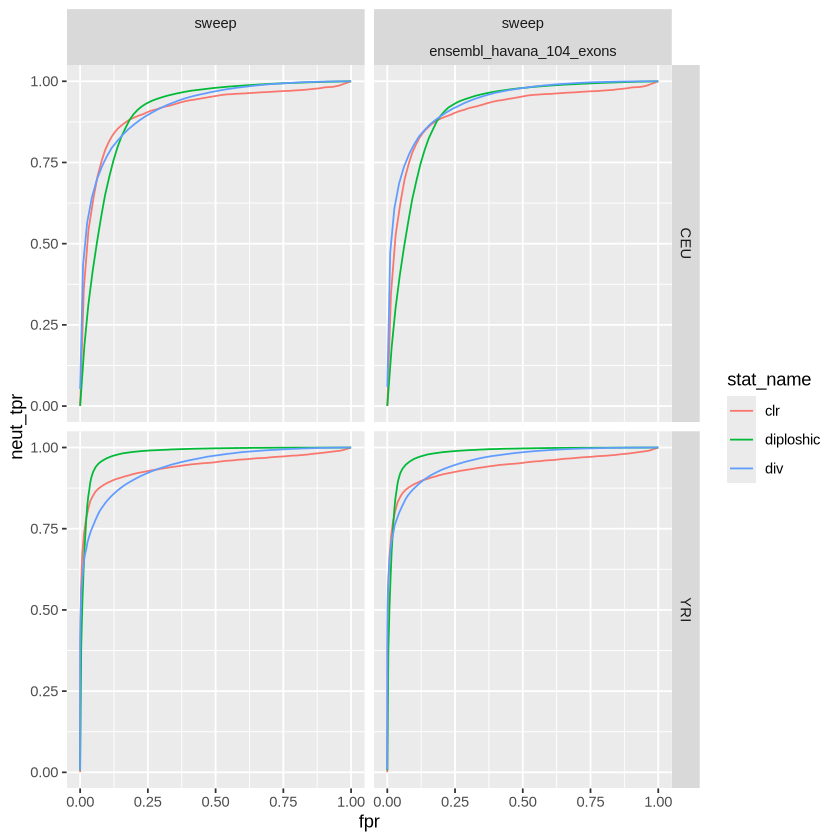

In [63]:
ggplot(joined, aes(y=neut_tpr,x=fpr, col=stat_name)) + geom_line() + facet_grid(pop~model.x+annot.x)

In [64]:
library(pracma)
auc_results <-  joined[joined$annot.x=="ensembl_havana_104_exons",]%>%
  group_by(stat_name, pop) %>%
  arrange(fpr) %>%  # Ensure FPR is ordered within each group
  summarise(AUC = trapz(fpr, neut_tpr))

# View the results
print(auc_results)


Attaching package: ‘pracma’


The following object is masked from ‘package:purrr’:

    cross


`summarise()` has grouped output by 'stat_name'. You can override using the
`.groups` argument.


# A tibble: 6 × 3
# Groups:   stat_name [3]
  stat_name pop     AUC
  <chr>     <chr> <dbl>
1 clr       CEU   0.906
2 clr       YRI   0.939
3 diploshic CEU   0.903
4 diploshic YRI   0.979
5 div       CEU   0.932
6 div       YRI   0.957


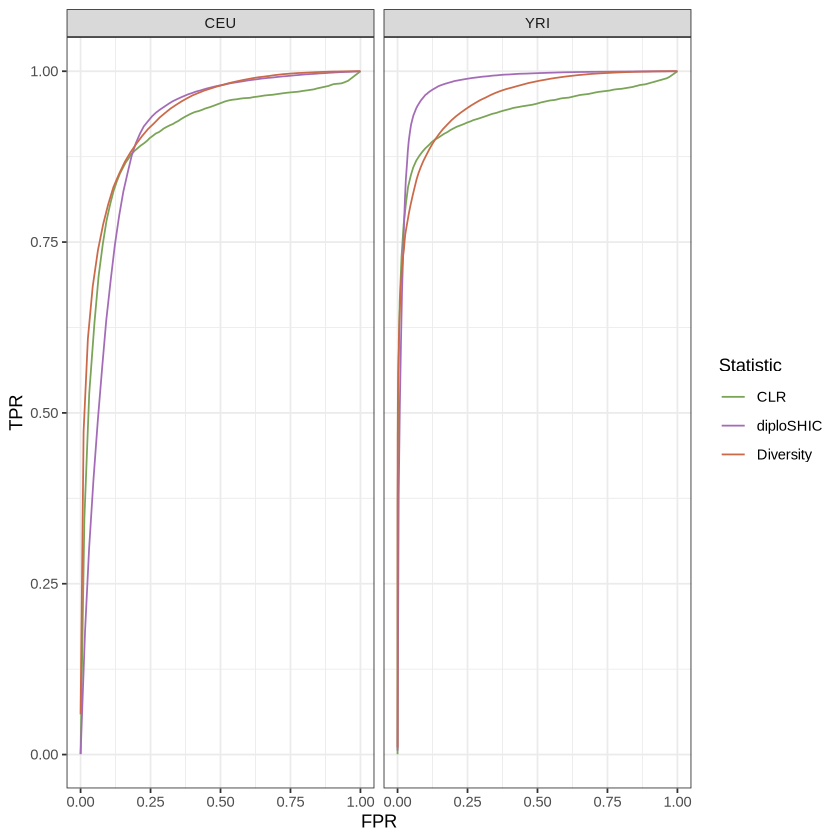

In [65]:
roc_neut_null = ggplot(joined[joined$annot.x=="ensembl_havana_104_exons",], 
       aes(y=neut_tpr,x=fpr, col=stat_name)) + 
        geom_line() + 
        facet_grid(~pop) +
        labs(x="FPR", y="TPR", col="Statistic") +
        theme_bw() +
        scale_color_manual(values = c("#7aa457","#a46cb7","#cb6a49"),
                     labels = c("CLR",
                                "diploSHIC",
                                "Diversity"))
roc_neut_null
ggsave(paste0("results/simulated_data/sweeps/roc_neutral_null.pdf"), width=9.5, height=4.5, scale=0.7)

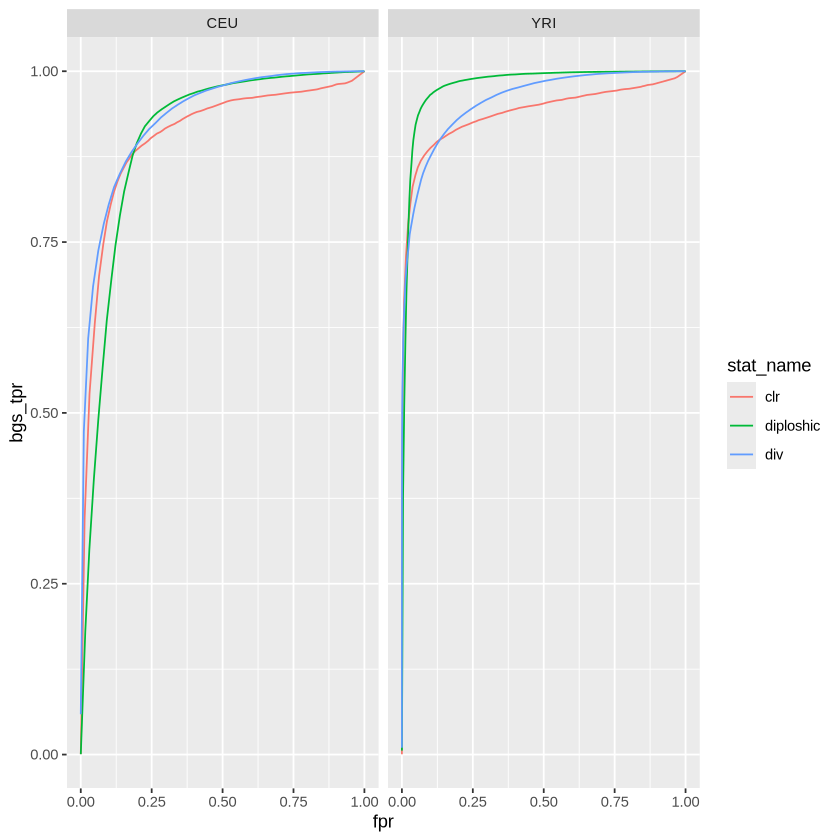

In [66]:
ggplot(joined[joined$annot.x=="ensembl_havana_104_exons",], 
       aes(y=bgs_tpr,x=fpr, col=stat_name)) + 
        geom_line() + 
        facet_grid(~pop)